In [1]:
!pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Dependencies

In [2]:
import copy
import os
from os import walk
import time
import shutil 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from PIL import Image
import cv2
import splitfolders

## Mount Data

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# %%capture
# !unzip /content/drive/MyDrive/aluminium.zip

In [4]:
!rm -vr ~/.kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
!chmod 777 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [5]:
api_token = {"username":"azzaali","key":"77d4f57492eab11f39f0a5babfc0ed29"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d danielbacioiu/tig-aluminium-5083

100% 11.2G/11.2G [01:51<00:00, 165MB/s]
100% 11.2G/11.2G [01:51<00:00, 108MB/s]


In [7]:
# %%capture
# !rm -vr /content/al5083
# !rm -vr /content/all_labeled
# !rm -vr /content/train_labeled
# !rm -vr /content/test_labeled

In [8]:
%%capture
!unzip /content/tig-aluminium-5083.zip
#!rm /content/tig-aluminium-5083.zip

# Label Data 

### train data

In [10]:
# Opening JSON file 
train_json = open('/content/al5083/train/train.json') 
label_train = json.load(train_json) 

In [11]:
keys_orig = list(label_train.keys())
values = list(label_train.values())
keys = []
for key in keys_orig:
  folder_name = key
  folder_name = folder_name.replace("/", " ")
  x = folder_name.split()
  string = x[0]+' '+x[1]
  keys.append(string)
true_labels_dict = {keys[i]: values[i] for i in range(len(keys))} 


In [12]:
location_folders = '/content/al5083/train/'
folders = []
for (_, dirnames, _) in walk(location_folders):
    folders.extend(dirnames)
    break

num_files = []
for folder in folders:
  location_files = location_folders + folder +'/'
  files =[]
  for (_, _, filenames) in walk(location_files):
    files.extend(filenames)
    break

  num_files.append(len(files))

num_files = np.array(num_files)


In [13]:
label = [true_labels_dict[folder] for folder in folders]
train_data = pd.DataFrame({'folders':folders,
                           'number_of_images':num_files,
                           'Labels':label })
train_data_labeled =train_data.sort_values(by=['Labels'])
train_data_labeled

,folders,number_of_images,Labels
45,170905-115602-Al 2mm,914,0
17,170913-142501-Al 2mm,770,0
16,170904-145718-Al 2mm-part1,619,0
44,170906-120346-Al 2mm,1165,0
25,170906-114912-Al 2mm,979,0
27,170905-114307-Al 2mm,844,0
18,170904-141730-Al 2mm-part1,394,0
28,170913-152931-Al 2mm-part1,354,0
34,170913-155806-Al 2mm-part1,932,0
39,170913-151508-Al 2mm-part1,371,0


In [14]:
train_data_labeled.drop(train_data_labeled[train_data_labeled['Labels'] == 0].index, axis=0, inplace=True)
train_data_labeled['Labels'] = train_data_labeled['Labels'] .replace([1,2,3,4,5],[0,1,2,3,4,]) 
train_data_labeled

,folders,number_of_images,Labels
26,170906-113317-Al 2mm-part3,55,0
13,170906-144958-Al 2mm,1728,0
32,170913-152931-Al 2mm-part2,189,1
33,170904-112347-Al 2mm,2460,1
37,170906-153326-Al 2mm-part2,47,1
21,170904-151845-Al 2mm-part2,28,1
40,170904-150144-Al 2mm-part1,115,1
20,170913-143933-Al 2mm-part2,178,1
0,170906-141809-Al 2mm-part2,396,1
6,170904-115959-Al 2mm,870,1


In [14]:
# making subfolders with the name of each class
# class_names=['0_Good weld','1_Burn through','2_Contamination','3_Lack of fusion','4_Misalignment','5_Lack of penetration']
# for i in class_names:
#       os.makedirs(os.path.join('train_labeled',i))

In [9]:
#class_names=['0_Good weld','1_Defect']
class_names=['1_Burn through','2_Contamination','3_Lack of fusion','4_Misalignment','5_Lack of penetration']
for i in class_names:
      os.makedirs(os.path.join('all_labeled',i))


In [15]:
def copy_to_folder_2classes(num, raw_data_folder ,data_labeled  ,new_folder_path ):
  #test_files='/content/al5083/test'
  for folder_n in list(data_labeled[data_labeled['Labels']== num]['folders']):
    #print(num,folder_n)

    for file in os.listdir(raw_data_folder):    
      location_files = os.path.join(raw_data_folder,folder_n)

      for (_, _, filenames) in walk(location_files):
          # print(filenames)  # lists of string contain images names 'frame_00813.png'

        for image in filenames:
          get_image = os.path.join(location_files,image)
          # print(get_image)  #/content/al5083/test/170906-143512-Al 2mm-part1/frame_01214.png

          new_image_name = folder_n + image
          shutil.move(get_image,os.path.join(location_files,new_image_name))
          shutil.move(os.path.join(location_files,new_image_name), new_folder_path + class_names[num])


In [16]:
for i in range(len(class_names)):
   copy_to_folder_2classes(i, location_folders , train_data_labeled  , '/content/all_labeled/')   

In [17]:
def get_images_name(folder, path='/content/train_labeled/'):
  images = set()
  for filename in os.listdir(path + folder):
    if filename.endswith("png"):
      images.add(path + folder + '/' + filename)
  return images

In [18]:
def plot_helper(plot_no=0, path='/content/all_labeled/'):
  if plot_no == 0:
    fig = plt.figure(0)
    fig.set_size_inches(30, 30)
    for idx, name in enumerate(class_names):
        images_names = list(get_images_name(name, path))
        for j in range(5):
            image = cv2.imread(images_names[j])
            ax = plt.subplot2grid((6,6), (idx,j))
            ax.set_title(name)
            plt.subplots_adjust(hspace=0.5)
            plt.imshow(image)
  elif plot_no == 1:
    class_length=[]
    for c in class_names:
      images_names = list(get_images_name(c, path))
      class_length.append(len(images_names))

    print("Dataset size is:", np.sum(np.array(class_length)))
    fig = plt.figure(0)
    fig.set_size_inches(20, 10)
    plt.bar(class_names,class_length)
    plt.show()


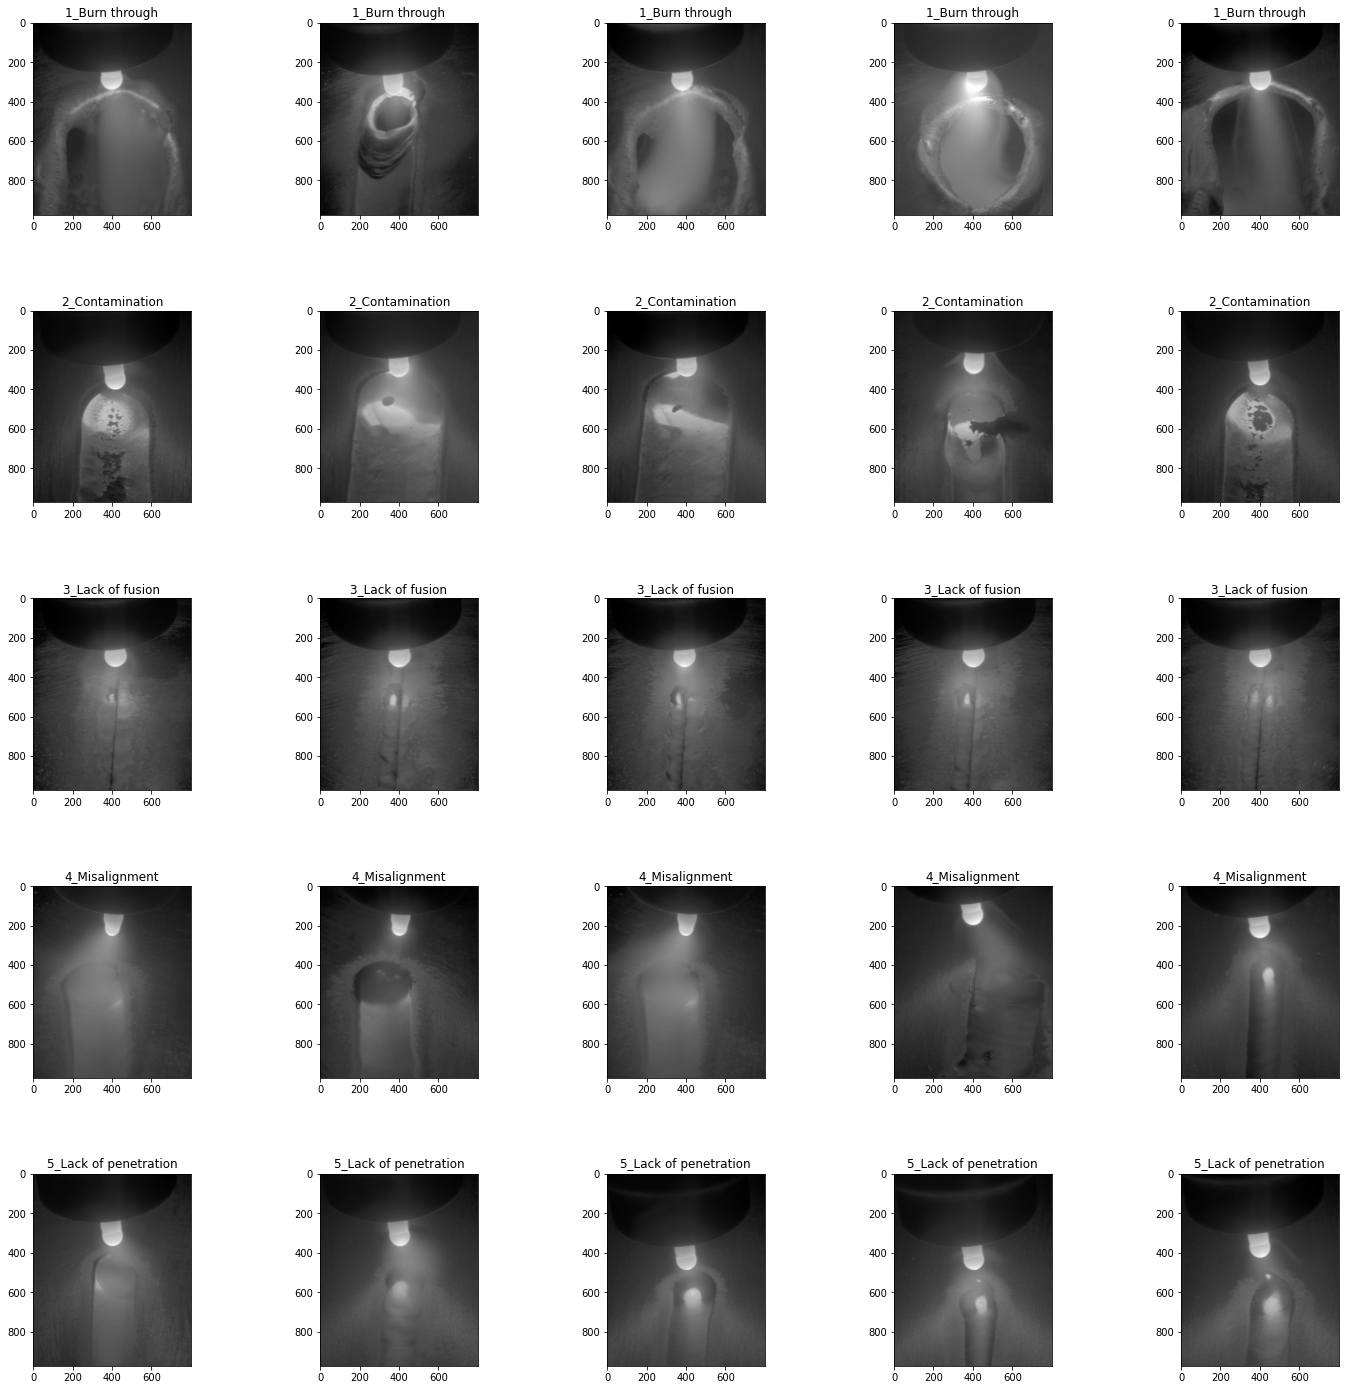

In [19]:
plot_helper()

Dataset size is: 17908


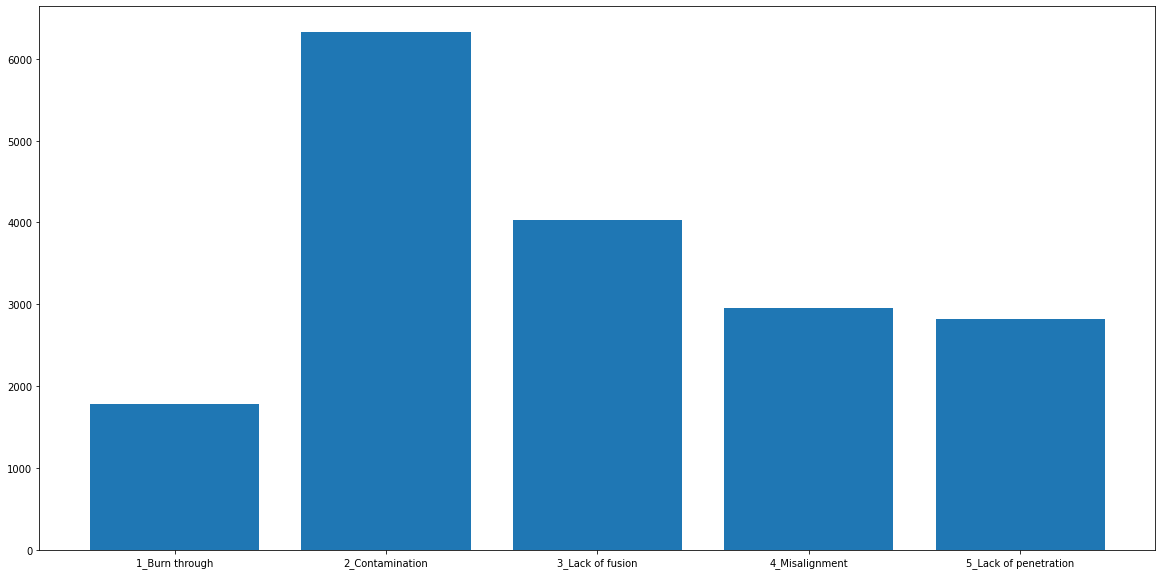

In [20]:
plot_helper(1)

### test data

In [21]:
test_json = open('/content/al5083/test/test.json') 
label_test = json.load(test_json) 

In [22]:
keys_orig = list(label_test.keys())
values = list(label_test.values())
keys = []
for key in keys_orig:
  folder_name = key
  folder_name = folder_name.replace("/", " ")
  x = folder_name.split()
  string = x[0]+' '+x[1]
  keys.append(string)
true_labels_dict_test = {keys[i]: values[i] for i in range(len(keys))} 


In [23]:
test_location_folders = '/content/al5083/test/'
test_folders = []
for (_, dirnames, _) in walk(test_location_folders):
    test_folders.extend(dirnames)
    break

test_num_files = []
for folder in test_folders:
  test_location_files = test_location_folders + folder +'/'
  files_test =[]
 
  for (_, _, filenames) in walk(test_location_files):
    files_test.extend(filenames)
   
    break

  test_num_files.append(len(files_test))

test_num_files = np.array(test_num_files)


In [24]:
label = [true_labels_dict_test[folder] for folder in test_folders]
test_data = pd.DataFrame({'folders':test_folders,
                           'number_of_images':test_num_files,
                           'Labels':label })
test_data_labeled =test_data.sort_values(by=['Labels'])
test_data_labeled

,folders,number_of_images,Labels
2,170905-112213-Al 2mm,585,0
3,170913-154448-Al 2mm,427,0
7,170906-104925-Al 2mm,651,0
11,170906-113317-Al 2mm-part1,526,0
12,170906-143512-Al 2mm-part2,351,1
4,170904-155610-Al 2mm,235,2
10,170906-143512-Al 2mm-part1,1212,2
13,170904-154202-Al 2mm-part1,631,2
0,170906-151724-Al 2mm-part1,402,3
1,170906-155007-Al 2mm-part1,451,3


In [25]:
test_data_labeled.drop(test_data_labeled[test_data_labeled['Labels'] == 0].index, axis=0, inplace=True)
test_data_labeled['Labels'] = test_data_labeled['Labels'] .replace([1,2,3,4,5],[0,1,2,3,4,]) 
test_data_labeled

,folders,number_of_images,Labels
12,170906-143512-Al 2mm-part2,351,0
4,170904-155610-Al 2mm,235,1
10,170906-143512-Al 2mm-part1,1212,1
13,170904-154202-Al 2mm-part1,631,1
0,170906-151724-Al 2mm-part1,402,2
1,170906-155007-Al 2mm-part1,451,2
5,170906-153326-Al 2mm-part3,154,2
8,170906-155007-Al 2mm-part2,399,3
9,170904-150144-Al 2mm-part2,330,3
6,170904-152301-Al 2mm-part2,234,4


In [26]:
# # making subfolders with the name of each class
# class_names=['0_Good weld','1_Burn through','2_Contamination','3_Lack of fusion','4_Misalignment','5_Lack of penetration']
# for i in class_names:
#       os.makedirs(os.path.join('test_labeled',i))
# for i in class_names:
#       os.makedirs(os.path.join('all_labeled',i))


In [27]:
for i in range(len(class_names)):
   copy_to_folder_2classes(i, test_location_folders , test_data_labeled  , '/content/all_labeled/')   


In [28]:
# !mv train_labeled.zip /content/drive/MyDrive
# !mv test_labeled.zip /content/drive/MyDrive

Dataset size is: 22307


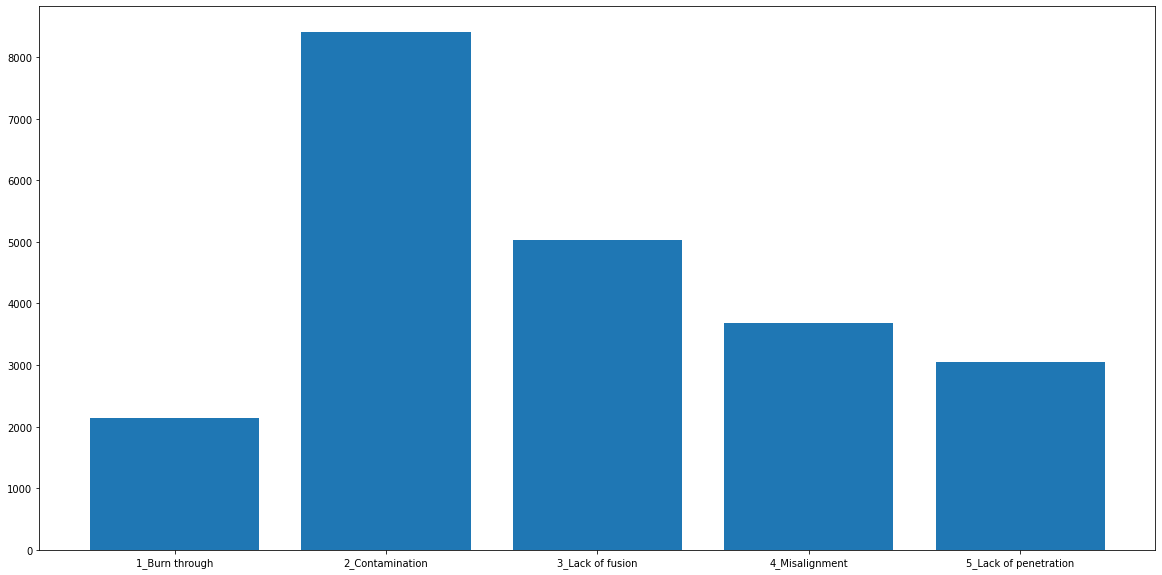

In [29]:
#ALL Dataset
plot_helper(1)

In [30]:
%%capture
!rm -vr /content/al5083

In [31]:
input_folder = "/content/all_labeled" #Enter Input Folder
output = "/content/" #Enter Output Folder

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(0.8,0.2))

Copying files: 22307 files [00:56, 395.04 files/s]


In [32]:
!mv /content/train /content/train_labeled
!mv /content/val /content/test_labeled

Dataset size is: 17844


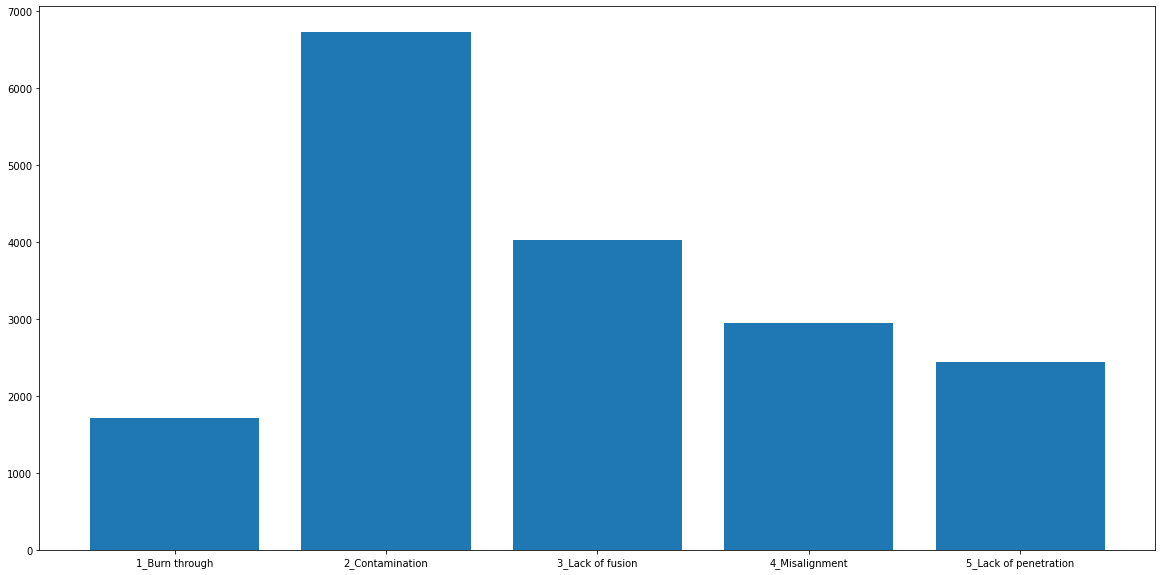

In [33]:
#Train Dataset
plot_helper(1, path="/content/train_labeled/")

Dataset size is: 4463


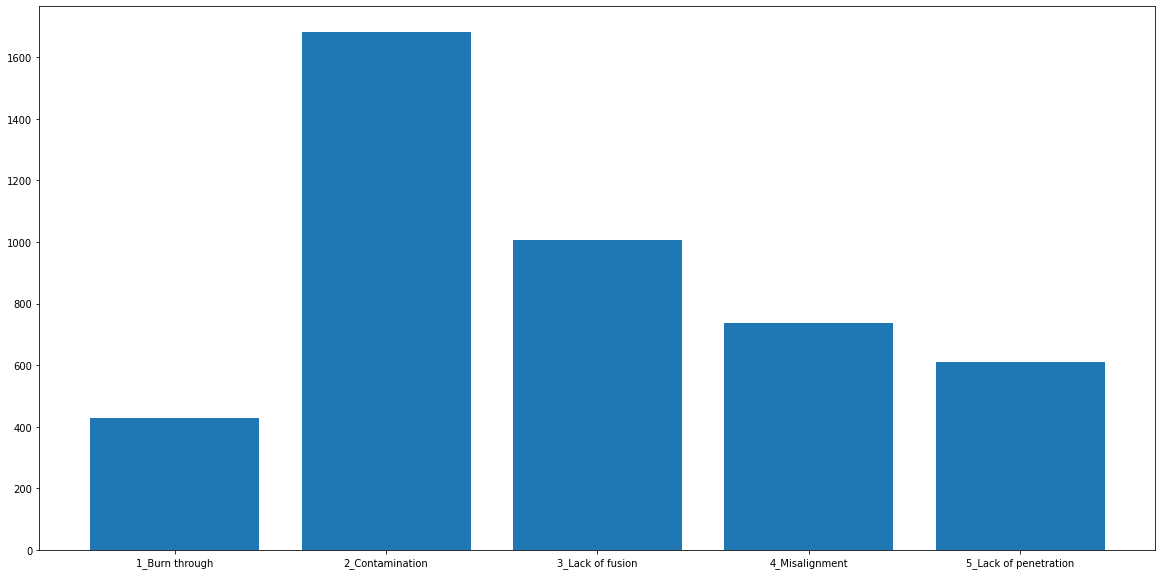

In [34]:
#Test Dataset
plot_helper(1, path="/content/test_labeled/")

## Model

In [35]:
# check avliable device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")


Running on device: cuda:0


In [36]:
from collections import Counter

train_dir = '/content/train_labeled/'
batch_size = 8
# create transforms
train_transforms = transforms.Compose([
            transforms.Resize(255),
            #transforms.AutoAugment(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
image_datasets = datasets.ImageFolder(train_dir, train_transforms)
train_set_size = int(len(image_datasets) * 0.8)
valid_set_size = len(image_datasets) - train_set_size
train_set, val_set = torch.utils.data.random_split(image_datasets, [train_set_size, valid_set_size])
dataloaders_dict = {'train':torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4), 'val':torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=4)}
print(f"Label Encoding: {image_datasets.class_to_idx}")

class_count_train = {label:0 for label in image_datasets.class_to_idx.values()}
class_count_val = {label:0 for label in image_datasets.class_to_idx.values()}
for _, label in train_set: class_count_train[label] +=1
for _, label in val_set: class_count_val[label] +=1

print(f"Train dataset size {len(train_set)} Class counts {class_count_train}")
print(f"Val dataset size {len(val_set)} Class counts {class_count_val}")

Label Encoding: {'1_Burn through': 0, '2_Contamination': 1, '3_Lack of fusion': 2, '4_Misalignment': 3, '5_Lack of penetration': 4}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train dataset size 14275 Class counts {0: 1370, 1: 5366, 2: 3231, 3: 2367, 4: 1941}
Val dataset size 3569 Class counts {0: 337, 1: 1356, 2: 797, 3: 578, 4: 501}


In [37]:
# training utility functions
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []
    val_loss = []
    train_loss = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'train':
                train_loss.append(epoch_loss)
            else:
                val_loss.append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_loss, val_loss


def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == " ":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "mobilenet_v3_small":
        model_ft = models.mobilenet_v3_small(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[3].in_features
        model_ft.classifier[3] = nn.Linear(num_ftrs, num_classes, bias=True)
        input_size = 224

    elif model_name == "squeeze_net":
        model_ft = models.squeezenet1_1(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
        input_size = 224

    elif model_name == "shuffle_net":
        model_ft = models.shufflenet_v2_x1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(in_features=num_ftrs, out_features=num_classes, bias=True)
        input_size = 224

    elif model_name == "efficient_net":
        model_ft = models.efficientnet_b0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(in_features=num_ftrs, out_features=num_classes, bias=True)
        input_size = 224


    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [38]:
print(models.squeezenet1_1())

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [39]:
feature_extract = True

# Number of classes in the dataset
num_classes = len(class_names)

model_name = 'squeeze_net'

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

model_ft = model_ft.to(device)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

In [40]:
# view parameters to learn
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t", name)


Params to learn:
	 classifier.1.weight
	 classifier.1.bias


Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.1863 Acc: 0.9351
val Loss: 0.0620 Acc: 0.9826

Epoch 1/9
----------
train Loss: 0.0640 Acc: 0.9812
val Loss: 0.0465 Acc: 0.9857

Epoch 2/9
----------
train Loss: 0.0449 Acc: 0.9873
val Loss: 0.0323 Acc: 0.9891

Epoch 3/9
----------
train Loss: 0.0390 Acc: 0.9873
val Loss: 0.0404 Acc: 0.9854

Epoch 4/9
----------
train Loss: 0.0319 Acc: 0.9910
val Loss: 0.0212 Acc: 0.9950

Epoch 5/9
----------
train Loss: 0.0314 Acc: 0.9898
val Loss: 0.0195 Acc: 0.9952

Epoch 6/9
----------
train Loss: 0.0269 Acc: 0.9919
val Loss: 0.0313 Acc: 0.9905

Epoch 7/9
----------
train Loss: 0.0245 Acc: 0.9931
val Loss: 0.0169 Acc: 0.9952

Epoch 8/9
----------
train Loss: 0.0252 Acc: 0.9923
val Loss: 0.0193 Acc: 0.9938

Epoch 9/9
----------
train Loss: 0.0213 Acc: 0.9940
val Loss: 0.0167 Acc: 0.9966

Training complete in 38m 47s
Best val Acc: 0.996638


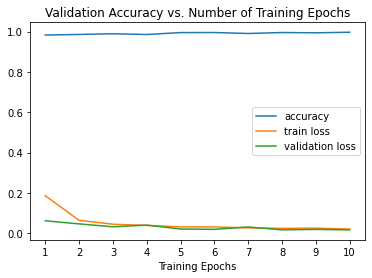

In [41]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

num_epochs = 10

# Train and evaluate
model_ft, hist, train_loss, val_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft,
                                                    num_epochs=num_epochs)
# saving best model

torch.save(model_ft.state_dict(), f'{model_name}.pth')

# plot validation
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
# plt.ylabel("Validation Accuracy")
plt.plot(range(1, num_epochs + 1), [h.cpu().numpy() for h in hist], label="accuracy")
plt.plot(range(1, num_epochs + 1), [h for h in train_loss], label="train loss")
plt.plot(range(1, num_epochs + 1), [h for h in val_loss], label="validation loss")
plt.xticks(np.arange(1, num_epochs + 1, 1.0))
plt.legend()
plt.show()


Load Model:

In [43]:
# model_path = '/content/squeeze_net.pt'
# model = torch.load(model_path)
# model.eval()



In [42]:
model_scripted = torch.jit.script(model_ft) # Export to TorchScript
model_scripted.save('/content/model_scripted.pt') # Save

model = torch.jit.load('model_scripted.pt')
model.eval()

RecursiveScriptModule(
  original_name=SqueezeNet
  (features): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=MaxPool2d)
    (3): RecursiveScriptModule(
      original_name=Fire
      (squeeze): RecursiveScriptModule(original_name=Conv2d)
      (squeeze_activation): RecursiveScriptModule(original_name=ReLU)
      (expand1x1): RecursiveScriptModule(original_name=Conv2d)
      (expand1x1_activation): RecursiveScriptModule(original_name=ReLU)
      (expand3x3): RecursiveScriptModule(original_name=Conv2d)
      (expand3x3_activation): RecursiveScriptModule(original_name=ReLU)
    )
    (4): RecursiveScriptModule(
      original_name=Fire
      (squeeze): RecursiveScriptModule(original_name=Conv2d)
      (squeeze_activation): RecursiveScriptModule(original_name=ReLU)
      (expand1x1): RecursiveScriptModule(original_name=Conv2d)
      (ex

lebelencoding {'1_Burn through': 0, '2_Contamination': 1, '3_Lack of fusion': 2, '4_Misalignment': 3, '5_Lack of penetration': 4} -- dataset size 4463
accuracy is 99.50705803271343 %
average inference speed is 5.235309748272444 ms
['1_Burn through', '2_Contamination', '3_Lack of fusion', '4_Misalignment', '5_Lack of penetration']


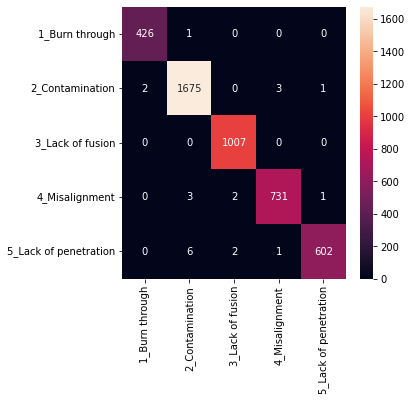

In [43]:
# Create dataset and dataloader
import statistics
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
test_ds = datasets.ImageFolder('/content/test_labeled/', train_transforms)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=2)

print(f"lebelencoding {test_ds.class_to_idx} -- dataset size {len(test_ds)}")
labels_dict = {v: k for k, v in test_ds.class_to_idx.items()}

running_corrects = 0
inference_time = []
y_pred = []
y_true = []
bads = 0
goods = 0
for inputs, labels in test_dl:
    st = time.time()
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
    running_corrects += torch.sum(preds == labels.data)
    et = time.time()
    inference_time.append(et - st)
    pred = preds.cpu()
    label = labels.cpu()
    y_pred.extend(pred)  # Save Prediction
    y_true.extend(label)  # Save Truth
    if pred == 0:
        bads +=1
    if pred == 1:
        goods +=1


acc = running_corrects.double() / len(test_ds)
print(f"accuracy is {acc * 100} %")
print(f"average inference speed is {statistics.mean(inference_time) * 1000} ms")
# plot confusion matrix
classes = list(test_ds.class_to_idx.keys())
print(classes)
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index=[i for i in classes],
                      columns=[i for i in classes])
plt.figure(figsize=(5, 5))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()


In [44]:
print(f"accuracy is {acc * 100} %")

accuracy is 99.50705803271343 %


In [45]:
torch.save(model_ft.state_dict(), f'{model_name}.pt')

In [46]:
y_pred

[tensor(1),
 tensor(2),
 tensor(4),
 tensor(0),
 tensor(2),
 tensor(4),
 tensor(1),
 tensor(2),
 tensor(1),
 tensor(2),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(2),
 tensor(0),
 tensor(4),
 tensor(1),
 tensor(3),
 tensor(0),
 tensor(1),
 tensor(1),
 tensor(2),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(2),
 tensor(3),
 tensor(3),
 tensor(3),
 tensor(2),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(4),
 tensor(2),
 tensor(3),
 tensor(2),
 tensor(1),
 tensor(1),
 tensor(3),
 tensor(2),
 tensor(1),
 tensor(3),
 tensor(3),
 tensor(1),
 tensor(2),
 tensor(3),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(3),
 tensor(3),
 tensor(1),
 tensor(1),
 tensor(3),
 tensor(1),
 tensor(1),
 tensor(2),
 tensor(3),
 tensor(4),
 tensor(2),
 tensor(1),
 tensor(3),
 tensor(2),
 tensor(1),
 tensor(4),
 tensor(3),
 tensor(3),
 tensor(4),
 tensor(2),
 tensor(0),
 tensor(2),
 tensor(0),
 tensor(2),
 tensor(2),
 tensor(2),
 tensor(1),
 tensor(2),
 tensor(3),
 ten